In [1]:
import os
import glob
import datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

2024-08-20 17:43:57.548721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 17:43:57.564293: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 17:43:57.568311: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-20 17:43:57.580109: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-20 17:43:58.495627: W tensorflow/compiler/tf2

## Input Data

In [2]:
batch_size = 32
img_height = 180
img_width = 180
data_dir = "../data/npy_no_overlap_60-images"

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode="binary",
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode="binary",
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 3936 files belonging to 2 classes.
Using 3149 files for training.


I0000 00:00:1724150640.062467   33425 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724150640.080967   33425 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724150640.081021   33425 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724150640.082854   33425 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724150640.082951   33425 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Found 3936 files belonging to 2 classes.
Using 787 files for validation.
['autism', 'normal']


2024-08-20 17:44:02.259790: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


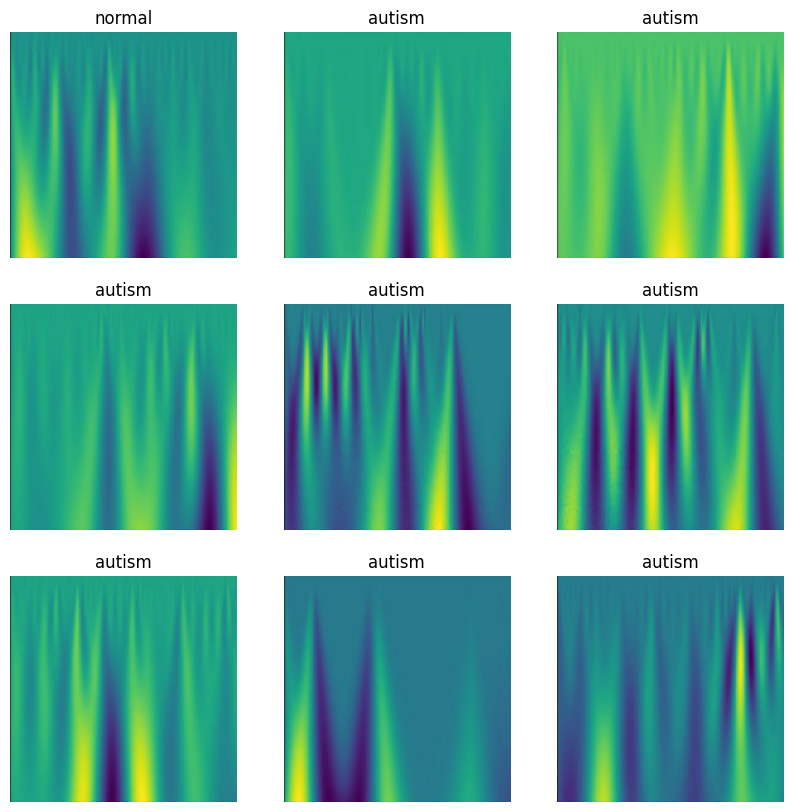

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    label = int(labels[i].numpy()[0])
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[label])
    plt.axis("off")

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
val_ds.element_spec[0]

TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None)

## Create Model

In [6]:
inputs = tf.keras.layers.Input(shape=(img_height, img_width, 3))

x = tf.keras.layers.Rescaling(1./255),
x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same")(inputs)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(32, kernel_size=(2, 2), padding="same")(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(32, kernel_size=(2, 2), padding="same")(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [7]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    15,860,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,870,913 (60.54 MB)

 Trainable params: 15,870,913 (60.54 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # loss=tf.keras.losses.BinaryFocalCrossentropy(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
])

In [9]:
log_dir = "logs/fit/" + "IMG-cwt-mexh-cnn-3-no-ovr-60" #datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# model.fit(train_ds, epochs=100, validation_data=test_ds, callbacks=[tensorboard_callback])
model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20


I0000 00:00:1724150646.491784   37627 service.cc:146] XLA service 0x7f0ef40030e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724150646.491826   37627 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-08-20 17:44:06.593588: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-20 17:44:06.955087: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 7/99 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5282 - auc: 0.5259 - fn: 21.0000 - fp: 38.2857 - loss: 191.1731 - prc: 0.2923 - precision: 0.2434 - recall: 0.4033 - tn: 53.7143 - tp: 15.0000

I0000 00:00:1724150650.354423   37627 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.6804 - auc: 0.6503 - fn: 235.3400 - fp: 207.3200 - loss: 44.4546 - prc: 0.4389 - precision: 0.4786 - recall: 0.4628 - tn: 904.6400 - tp: 262.6800 - val_accuracy: 0.9771 - val_auc: 0.9968 - val_fn: 0.0000e+00 - val_fp: 18.0000 - val_loss: 0.0887 - val_prc: 0.9918 - val_precision: 0.9328 - val_recall: 1.0000 - val_tn: 519.0000 - val_tp: 250.0000
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9893 - auc: 0.9989 - fn: 4.7200 - fp: 9.9700 - loss: 0.0417 - prc: 0.9976 - precision: 0.9782 - recall: 0.9903 - tn: 1070.5100 - tp: 522.8800 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_fn: 0.0000e+00 - val_fp: 0.0000e+00 - val_loss: 0.0049 - val_prc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_tn: 537.0000 - val_tp: 250.0000
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - auc: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0025 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - tn:

In [10]:
# model.export("../data/models/v1")

## Evaluate

In [11]:
model.evaluate(val_ds)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - auc: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 1.8298e-05 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - tn: 288.6923 - tp: 141.0769


[1.8039127098745666e-05, 250.0, 0.0, 537.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [14]:
X_test = []
y_test = []

for image_batches, label_batches in val_ds.as_numpy_iterator():
    for image, label in zip(image_batches, label_batches):
        X_test.append(image)
        y_test.append(label)

In [17]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [19]:
y_pred = model.predict(X_test) > 0.5

print("MCC:", np.round(matthews_corrcoef(y_test, y_pred), 4))
print("Accuracy:", np.round(accuracy_score(y_test, y_pred), 4))
print("Precision:", np.round(precision_score(y_test, y_pred), 4))
print("Recall:", np.round(recall_score(y_test, y_pred), 4))
print("F1:", np.round(f1_score(y_test, y_pred), 4))

print(classification_report(y_test, y_pred))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MCC: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       537
         1.0       1.00      1.00      1.00       250

    accuracy                           1.00       787
   macro avg       1.00      1.00      1.00       787
weighted avg       1.00      1.00      1.00       787



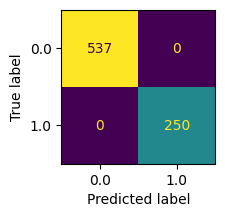

In [20]:
fig, ax = plt.subplots(figsize=(2, 2))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)